In [21]:
pwd

'g:\\Shared drives\\code\\projects\\pcmo\\notebooks'

# imports

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['font.size'] = 16
import xarray as xr
import sys
from tqdm.notebook import tqdm
from time import time
from glob import glob
from os.path import exists
import pandas as pd

# load data

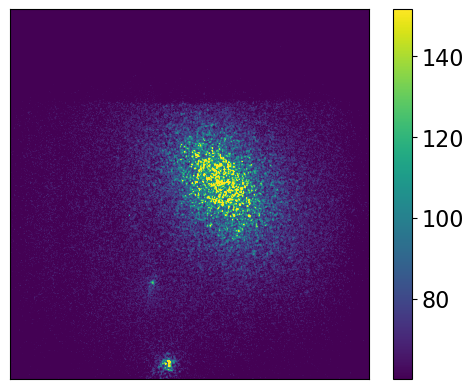

In [50]:
file = r'../data/232.0K.h5'
ds = xr.open_dataset(file)
img = ds['image_stack'][-10:].mean(axis=0).to_numpy()

plt.figure()
plt.imshow(img, vmin=np.percentile(img, 50), vmax=np.percentile(img, 99.5))
plt.xticks([])
plt.yticks([])
plt.colorbar()
plt.show()

In [40]:
file = r'../data/232.0K_reduced.h5'
ds = xr.open_dataset(file)
img = ds['image_stack'][1:10].mean(axis=0).to_numpy()

file = r'../data/230.0K_g2.h5'
ds = xr.open_dataset(file)
temp = ds.temperature
ds

<xarray.Dataset>
Dimensions:   (g2: 2400, row: 800, col: 800, lags: 2400)
Coordinates:
  * lags      (lags) int32 0 1 2 3 4 5 6 ... 2393 2394 2395 2396 2397 2398 2399
  * row       (row) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
  * col       (col) int32 0 1 2 3 4 5 6 7 8 ... 792 793 794 795 796 797 798 799
Dimensions without coordinates: g2
Data variables:
    g2_stack  (g2, row, col) float32 ...
Attributes:
    temperature:  230.0

In [4]:
g = ds['g2_stack'].to_numpy()
g.shape

(2400, 800, 800)

In [11]:
df = pd.read_pickle('../data/peak_fits_df.pkl')
df

amplitude     centerx     centery      sigmax      sigmay  rotation  \
0  41937.338306  379.687379  399.532913  124.334578  178.983157  0.710627   
1  12560.665054  381.280122  393.046973  123.131163  173.734293  0.821249   
2  74129.271548  388.779604  424.795670  114.763122  168.894653  0.895382   
3  38468.460672  396.883439  426.765337  108.885369  163.928508  0.891691   
4  11543.095339  407.698380  418.535864  109.137808  165.873185  0.890049   
5  49750.135279  430.424846  374.523392  110.923325  170.120108  0.855936   

     offset  rotation_error  amplitude_error  sigmax_error  sigmay_error  \
0  0.997101        0.005670       179.899031      0.406900      0.586042   
1  0.999304        0.006360        56.053734      0.432468      0.602721   
2  1.000855        0.003897       211.697682      0.242452      0.364951   
3  1.001765        0.005056       154.894125      0.351157      0.526546   
4  0.998925        0.006898        65.049006      0.501577      0.755594   
5  0.993975        0.004377       183.388357      0.305353      0.517594   

   centerx_error  centery_error  offset_error  temperature  
0       0.336860       0.355482      0.000352        200.0  
1       0.365825       0.357446      0.000109        225.0  
2       0.243583       0.223599      0.000482        230.0  
3       0.327640       0.301999      0.000343        230.5  
4       0.467169       0.430187      0.000137        231.0  
5       0.305478       0.285435      0.000400        232.0

In [12]:
from lmfit.lineshapes import lorentzian
# https://lmfit.github.io/lmfit-py/examples/example_two_dimensional_peak.html
def lorentzian2d(x, y, amplitude=1., centerx=0., centery=0., sigmax=1., sigmay=1.,
                 rotation=0, offset = 0, *args, **kwargs):
    """Return a two dimensional lorentzian.

    The maximum of the peak occurs at ``centerx`` and ``centery``
    with widths ``sigmax`` and ``sigmay`` in the x and y directions
    respectively. The peak can be rotated by choosing the value of ``rotation``
    in radians.
    """
    xp = (x - centerx)*np.cos(rotation) - (y - centery)*np.sin(rotation)
    yp = (x - centerx)*np.sin(rotation) + (y - centery)*np.cos(rotation)
    R = (xp/sigmax)**2 + (yp/sigmay)**2

    return 2*amplitude*lorentzian(R)/(np.pi*sigmax*sigmay) + offset

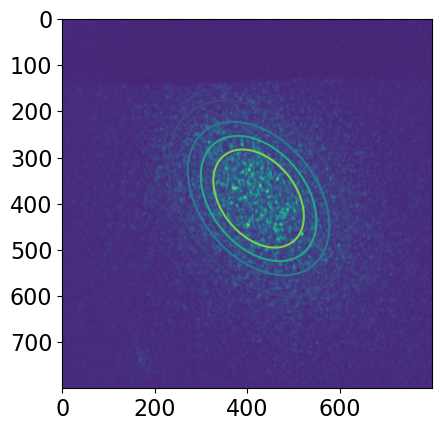

In [13]:
x, y = np.indices(img.shape)


fit = lorentzian2d(x.ravel(), y.ravel(), **df[df['temperature']==temp].to_dict('records')[0]).reshape(img.shape)
fit -= np.nanmin(fit)
fit /= np.nanmax(fit)

plt.figure()
plt.imshow(img)
plt.contour(fit, levels=5)
plt.show()

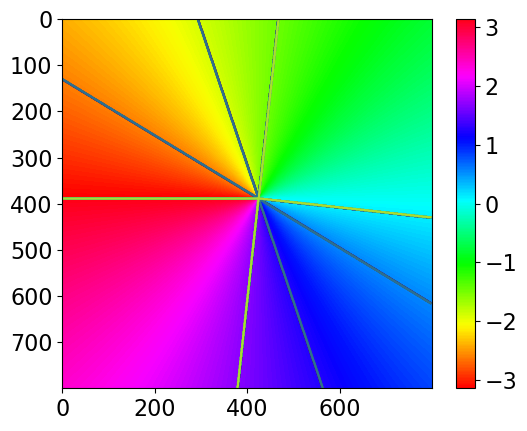

In [14]:
from skbeam.core import utils

center = (df[df['temperature']==temp].to_dict('records')[0]['centerx'],df[df['temperature']==temp].to_dict('records')[0]['centery'])
shape = fit.shape
angle_grid = utils.angle_grid(center, shape)
rot = df[df['temperature']==temp].to_dict('records')[0]['rotation']

angle = np.deg2rad(20)
angle_label = np.zeros_like(angle_grid)
angle_label[np.logical_and(angle_grid<(rot+angle), angle_grid>(rot-angle))] = 1
angle_label[np.logical_and(angle_grid<(rot+angle-np.pi), angle_grid>(rot-angle-np.pi))] = 1

angle = np.deg2rad(45)
angle_label[np.logical_and(angle_grid<(rot+angle-np.pi/2), angle_grid>(rot-angle-np.pi/2))] = 2
angle_label[np.logical_and(angle_grid<(rot+angle+np.pi/2), angle_grid>(rot-angle+np.pi/2))] = 2

plt.imshow(angle_grid, cmap='hsv')
plt.colorbar()
plt.contour(angle_label)
plt.show()

In [15]:
pixel_size = (20e-6, 20e-6) # m
sample_distance = 305e-3 # m
wavelength = (1240/638.7) #nm Mn L3
center = (df[df['temperature']==temp].to_dict('records')[0]['centerx'],df[df['temperature']==temp].to_dict('records')[0]['centery'])
shape = fit.shape

q_grid = utils.twotheta_to_q(utils.radius_to_twotheta(sample_distance, utils.radial_grid(center, shape, pixel_size)), wavelength)

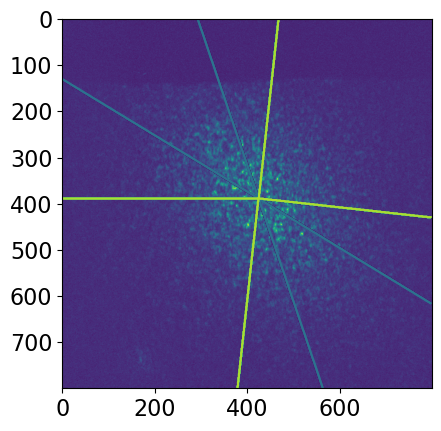

In [16]:
plt.figure()
plt.imshow(img)
plt.contour(angle_label)
plt.show()

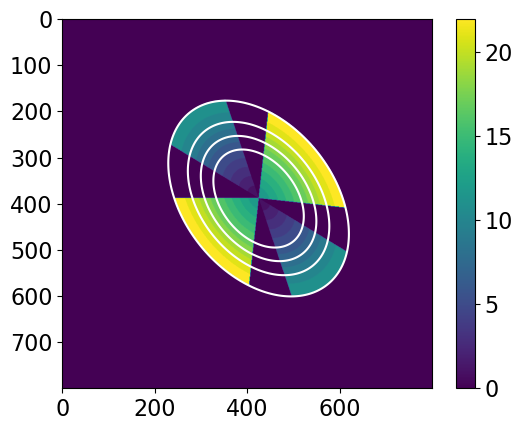

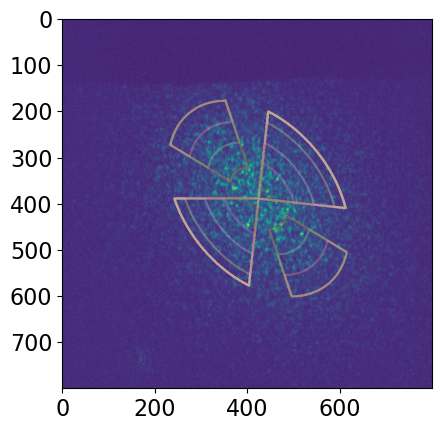

In [20]:
labels = np.zeros_like(fit)
levels = [1, .999, .99, .96, .90, .8, 0.7, 0.6, 0.5, 0.4, 0.3, 0.2]

for i in range(1, len(levels)):
    labels[np.logical_and(fit<levels[i-1], fit>levels[i])] = i
    
labels[angle_label==0] = 0
labels[np.logical_and(angle_label==2, labels!=0)] += np.amax(np.unique(labels))
    

plt.figure()
plt.imshow(labels)
plt.colorbar()
plt.contour(fit, levels=5, colors=['w'])
plt.show()

plt.figure()
plt.imshow(img)
plt.contour(labels, alpha=0.3, cmap='tab20')
plt.show()

q = np.array([np.mean(q_grid[labels==ul]) for ul in np.unique(labels)])

In [23]:
g2_img = g / g[0]

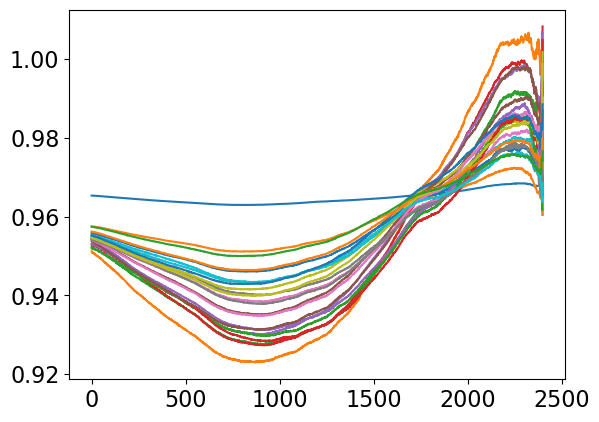

In [24]:
plt.figure()
for ul in np.unique(labels):
    mask = labels == ul
    plt.plot(g2_img[1:, mask].mean(axis=(-1)))
    
plt.show()

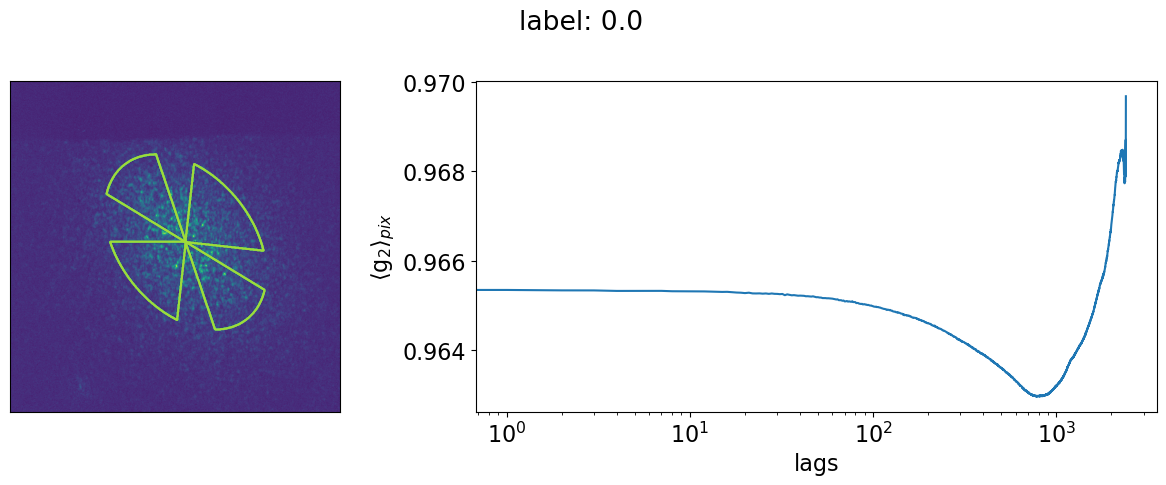

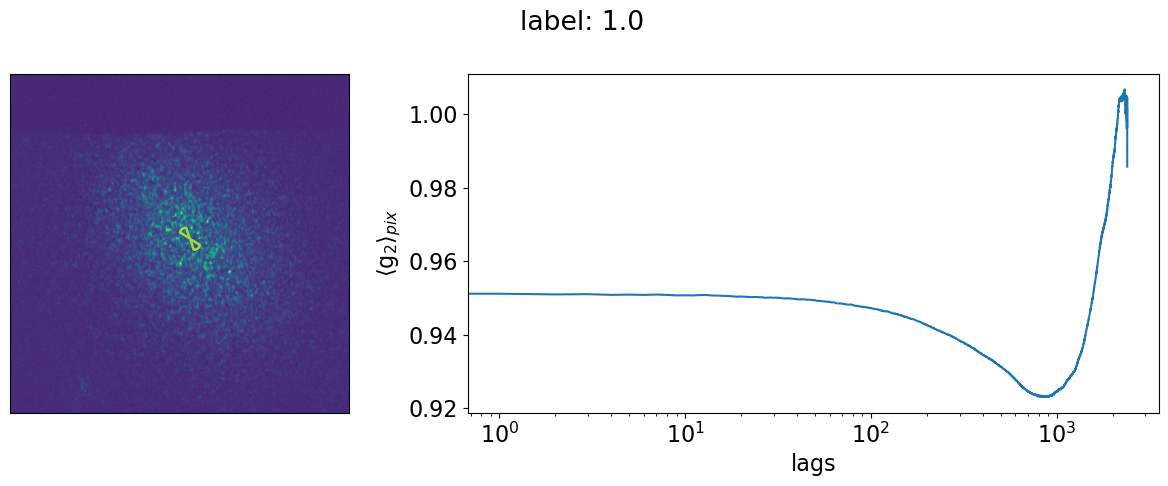

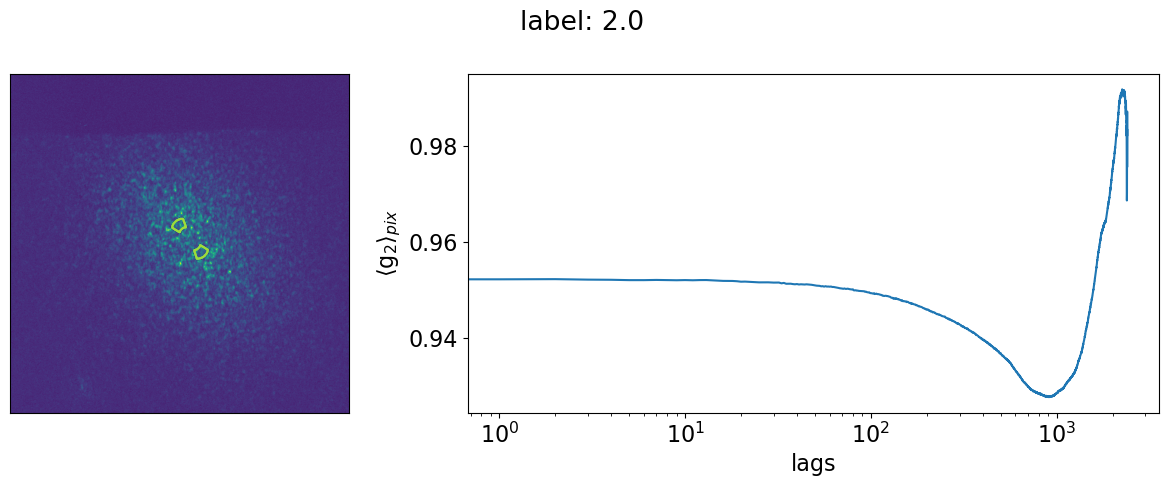

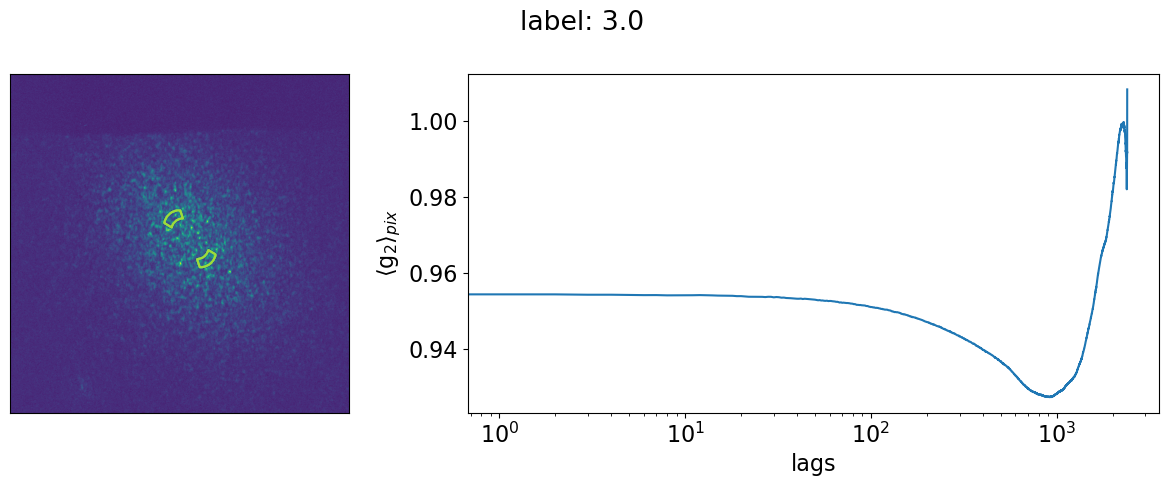

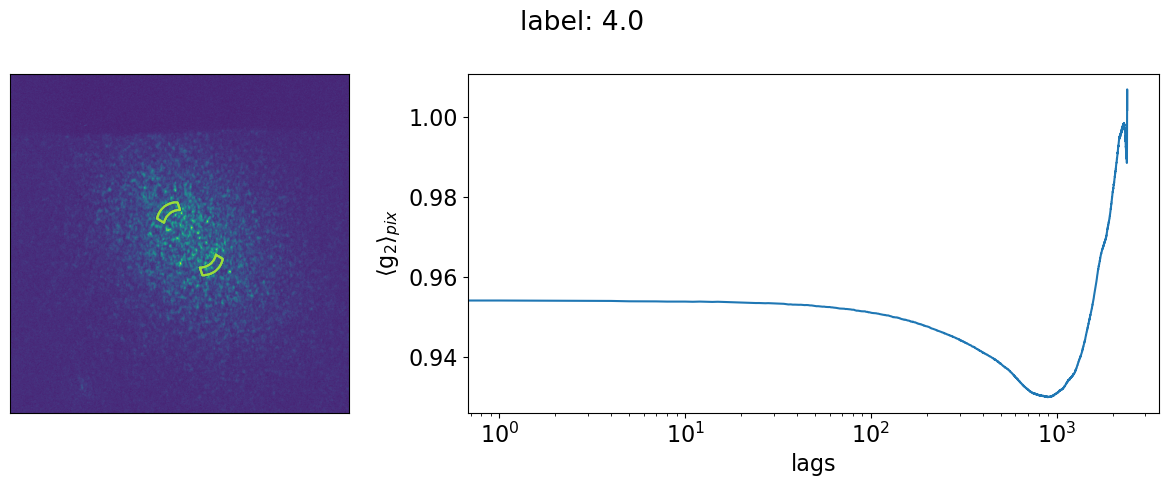

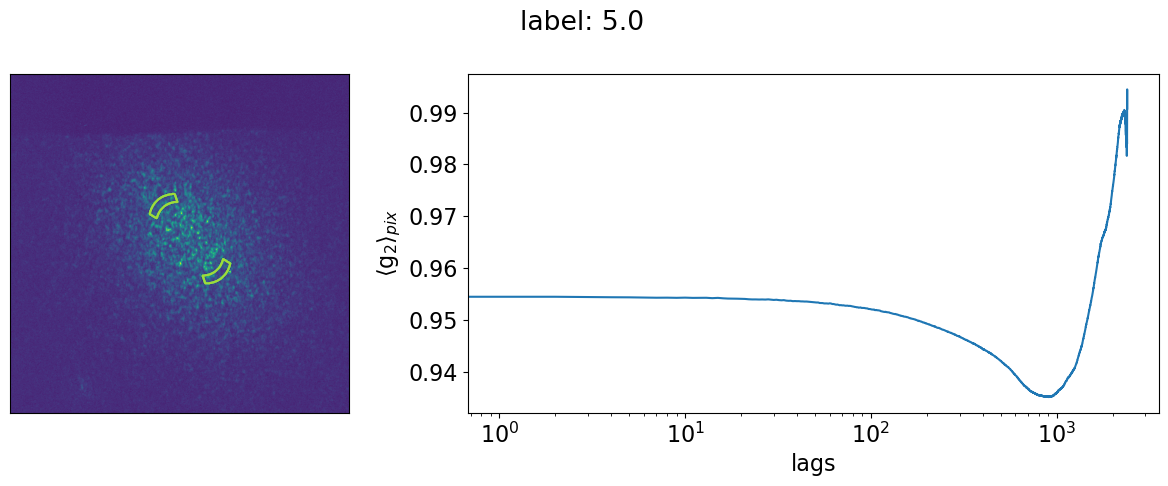

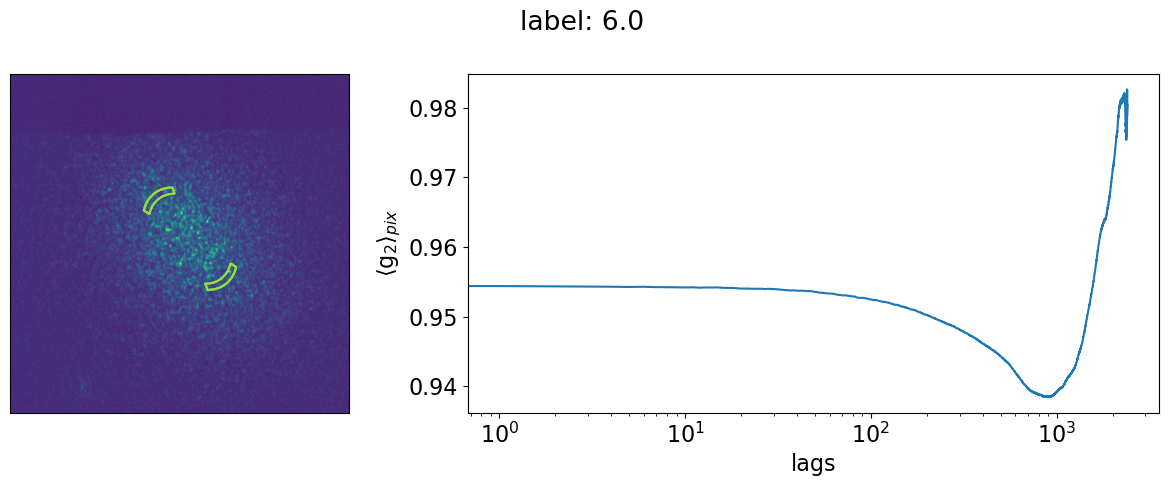

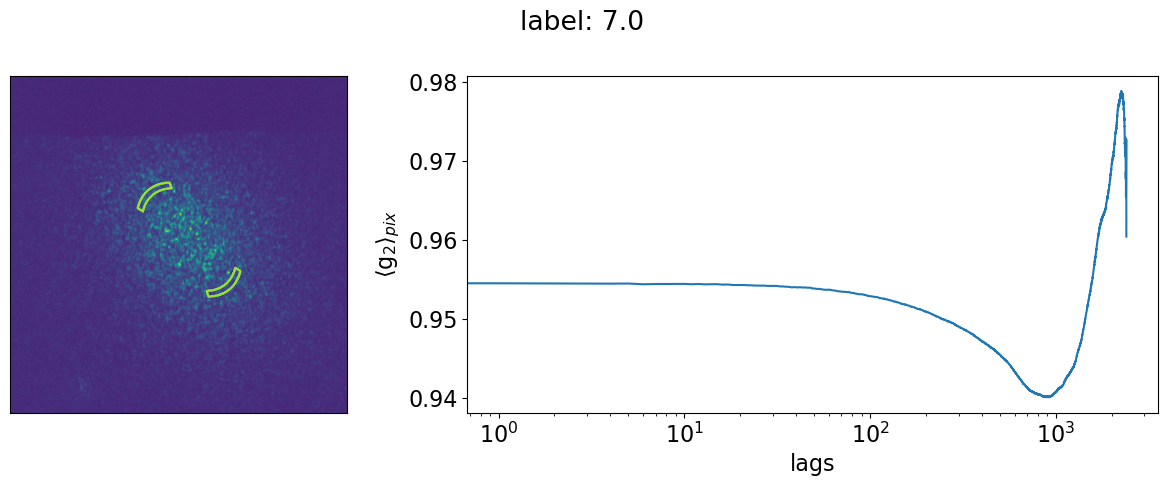

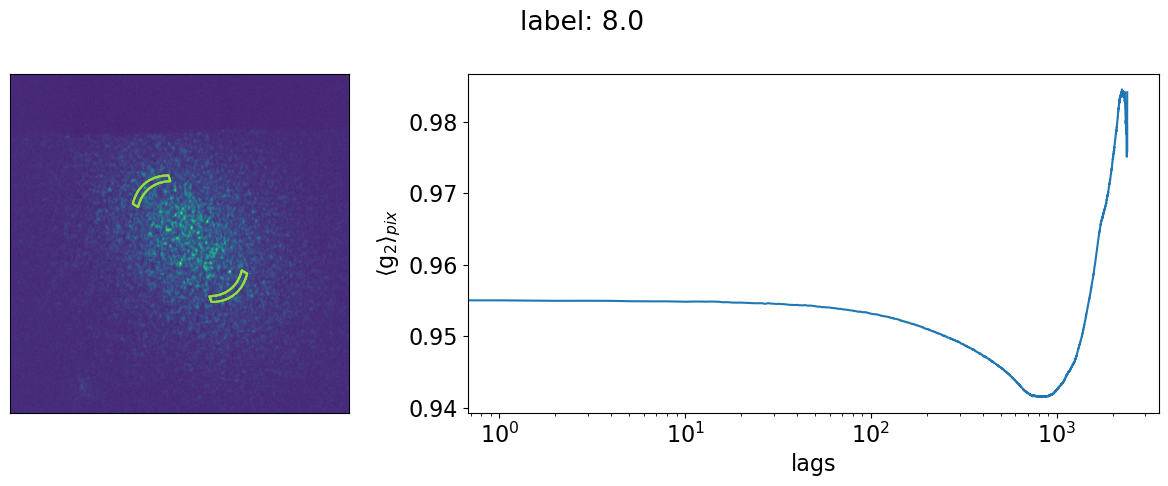

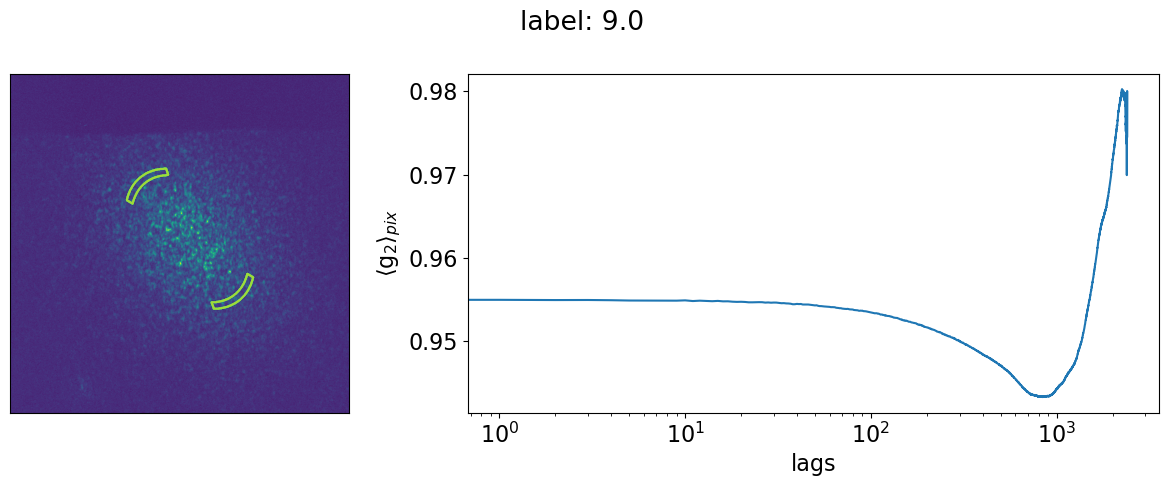

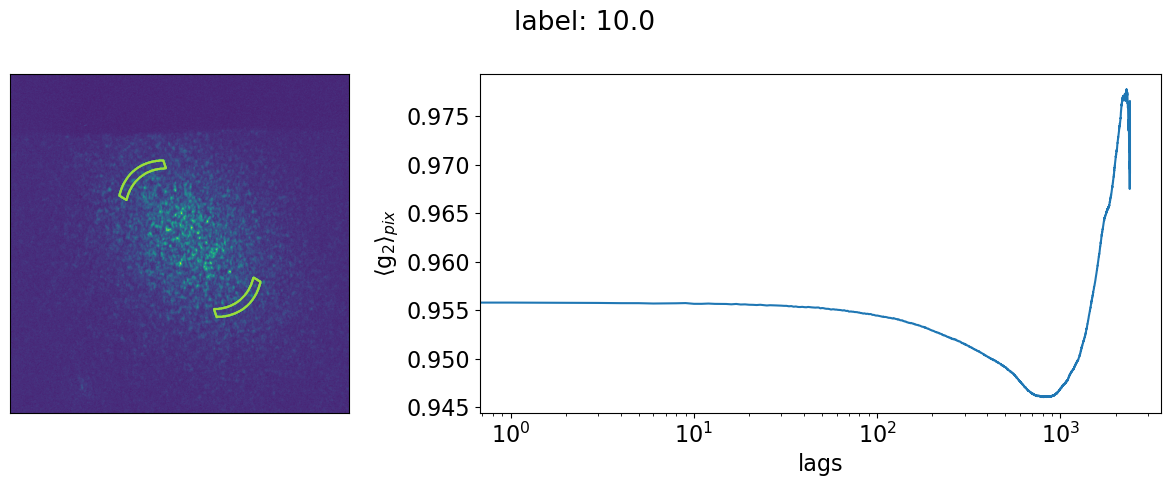

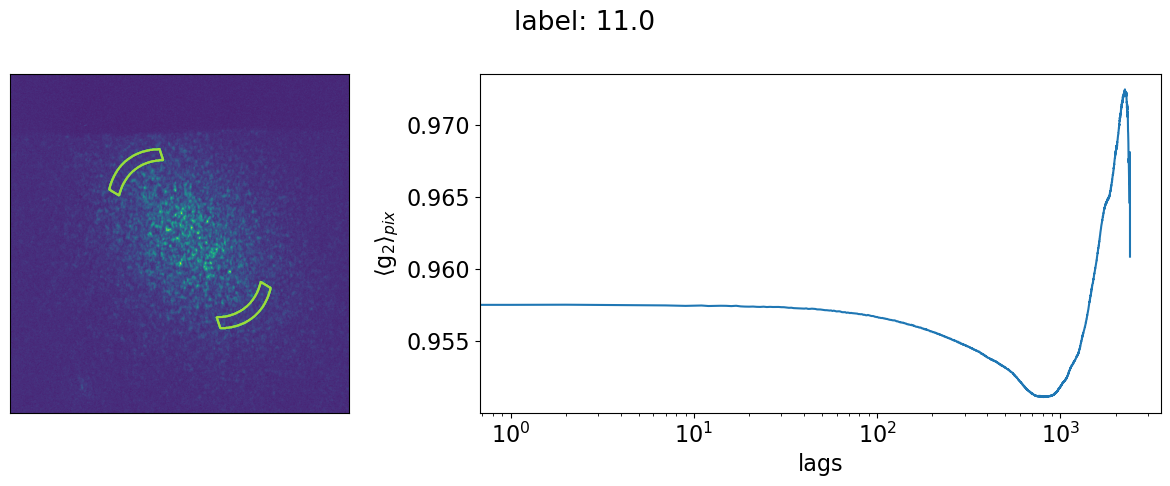

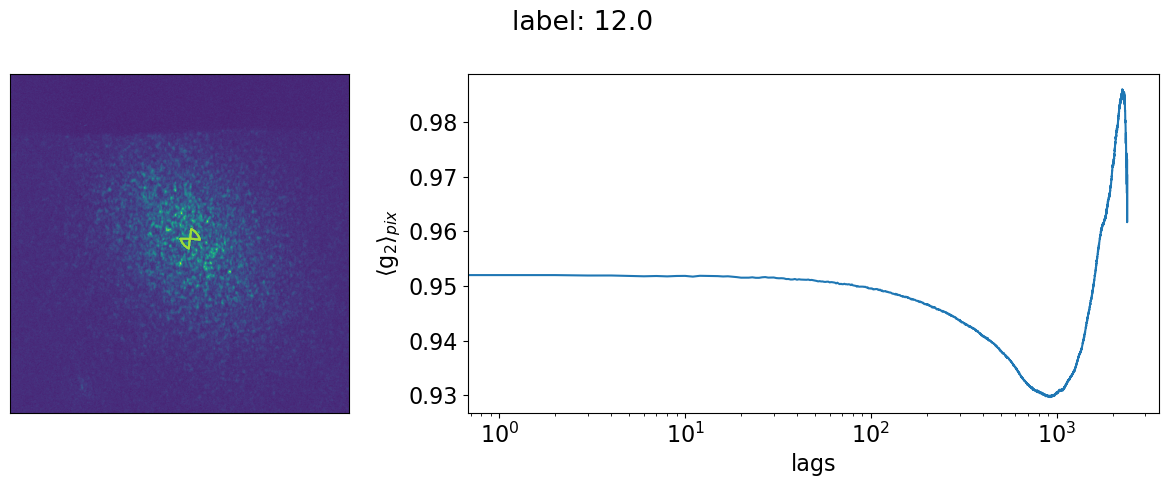

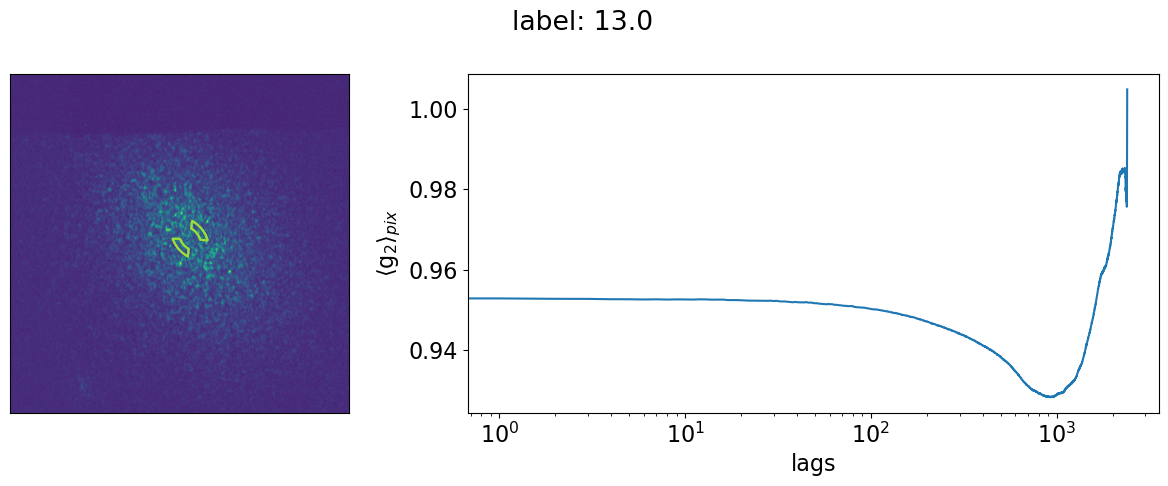

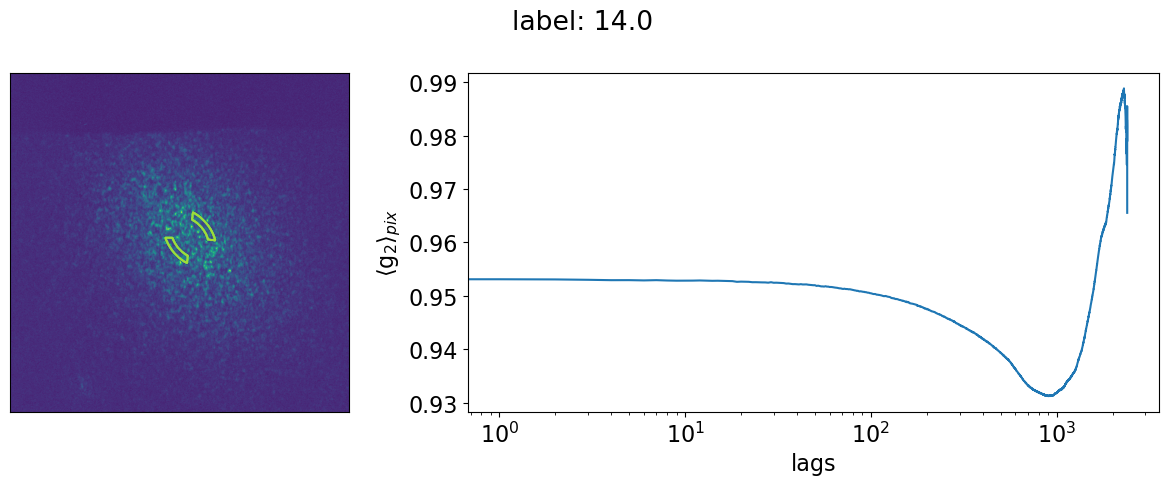

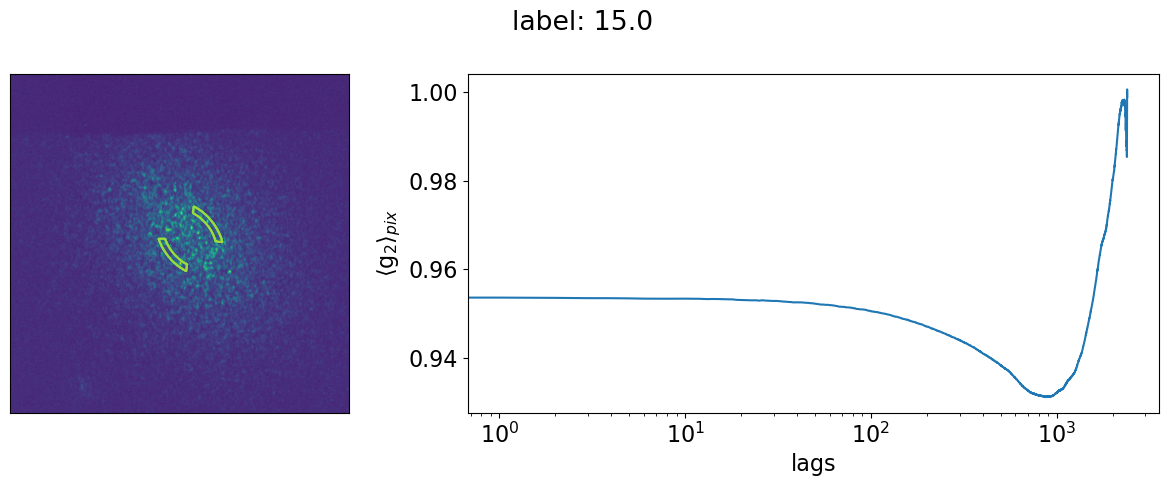

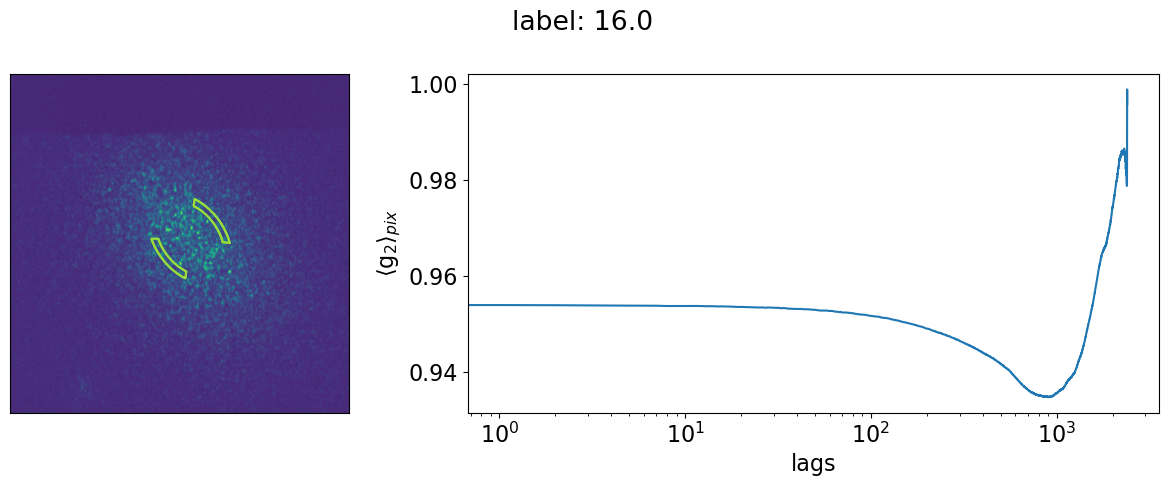

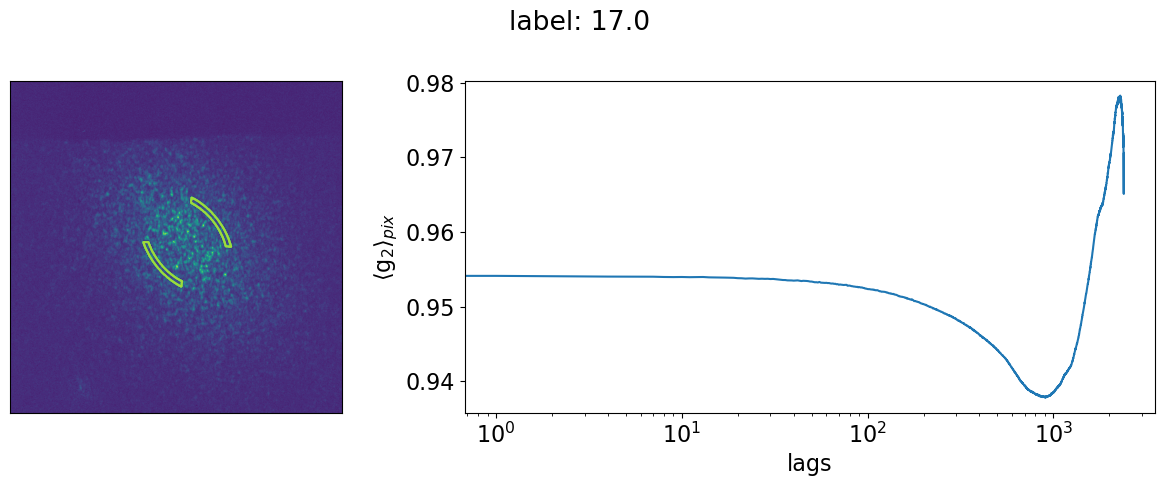

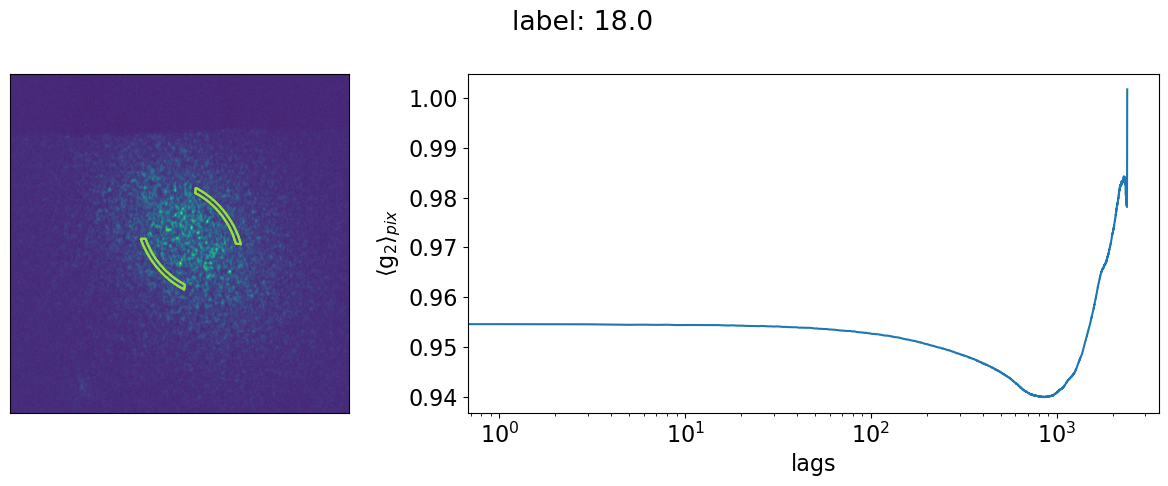

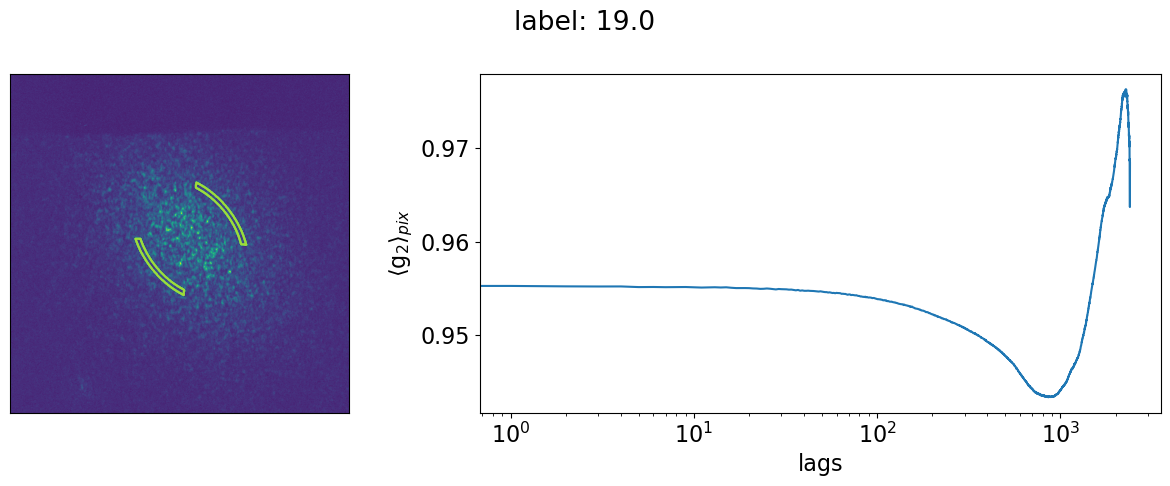

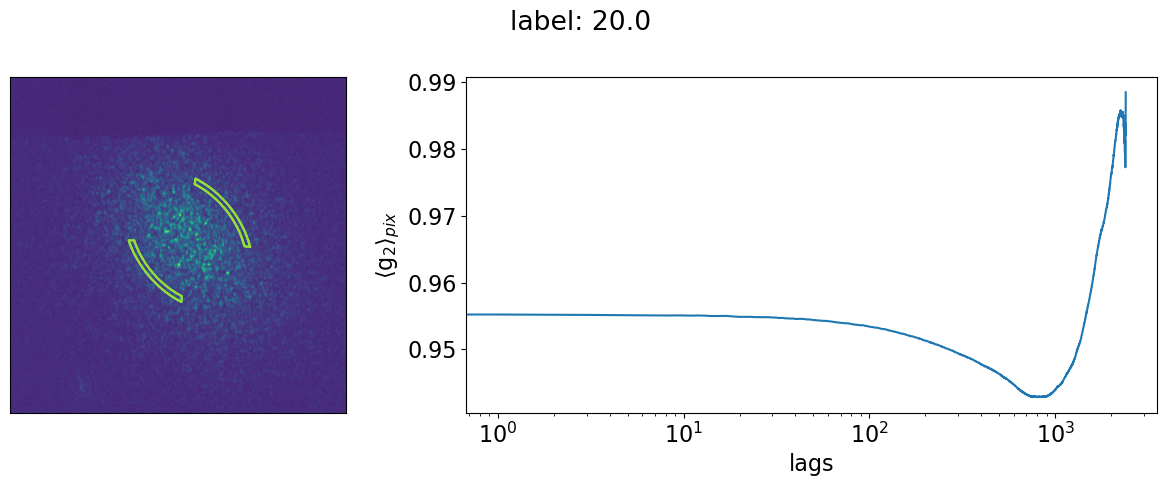

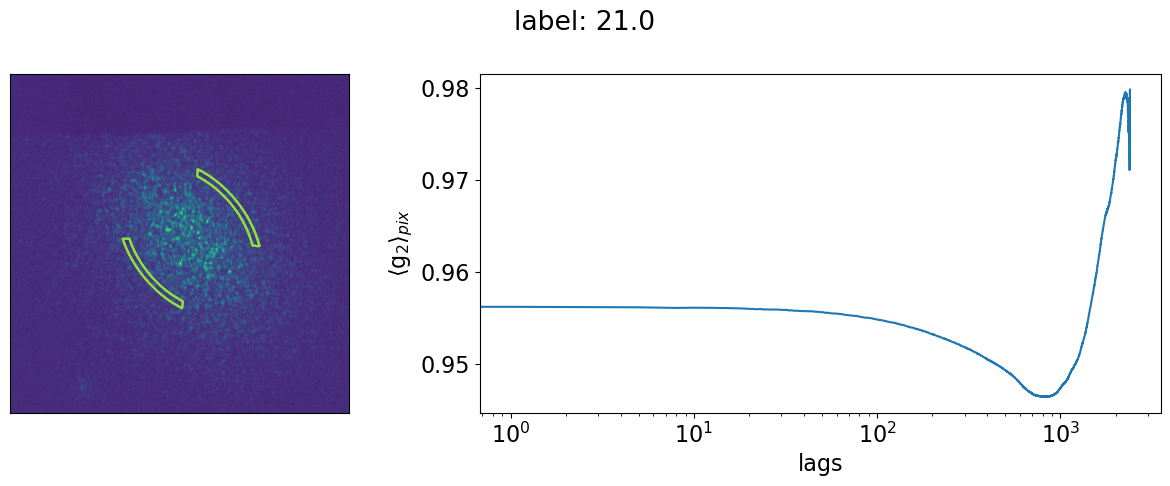

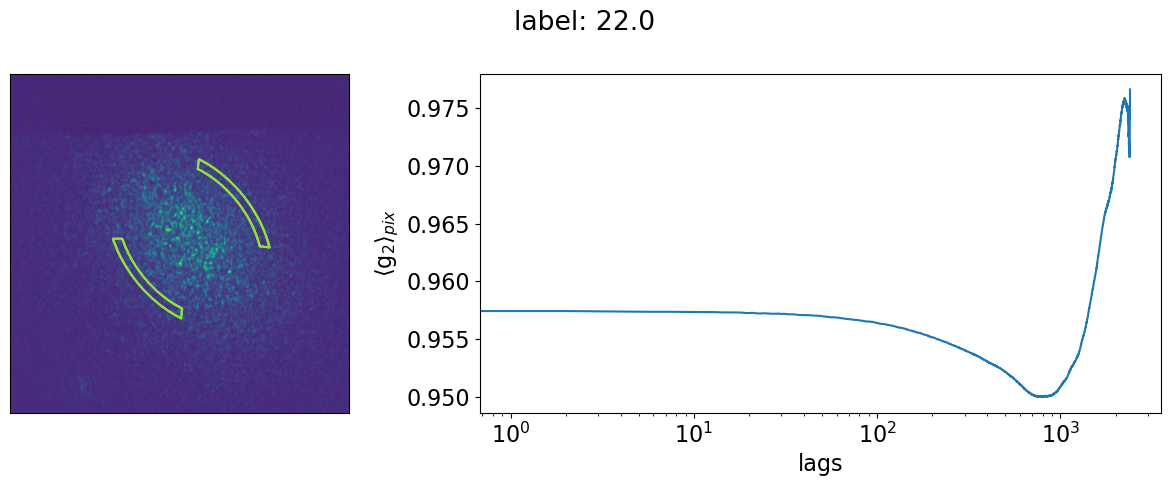

In [27]:
import matplotlib.colors as colors
import matplotlib as mpl
from sklearn.cluster import KMeans
mpl.rcParams['font.size'] = 16

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    # https://stackoverflow.com/questions/18926031/how-to-extract-a-subset-of-a-colormap-as-a-new-colormap-in-matplotlib
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

tmp = []
for ul in np.unique(labels):
    mask = labels == ul
    g2 = g2_img[1:, mask].mean(axis=(-1))
    img_overlay = np.zeros_like(labels)
    img_overlay[mask] = 1


    fig, ax = plt.subplots(figsize=(12,5), ncols=2, gridspec_kw={'width_ratios': [1, 2]})
    plt.suptitle(f'label: {ul}')

    ax[0].imshow(img)
    ax[0].contour(img_overlay)

    ax[1].plot(g2)
    ax[1].set_ylabel(r'$\langle$g$_2 \rangle_{pix}$')
    ax[1].set_xlabel('lags')
    ax[1].semilogx()
    ax[0].set_xticks([])
    ax[0].set_yticks([])
    plt.tight_layout()
    plt.show()

    tmp.append(g2)

In [30]:
tmp.shape

AttributeError: 'list' object has no attribute 'shape'

In [31]:
tmp = np.array(tmp)

In [32]:
tmp.shape

(23, 2399)

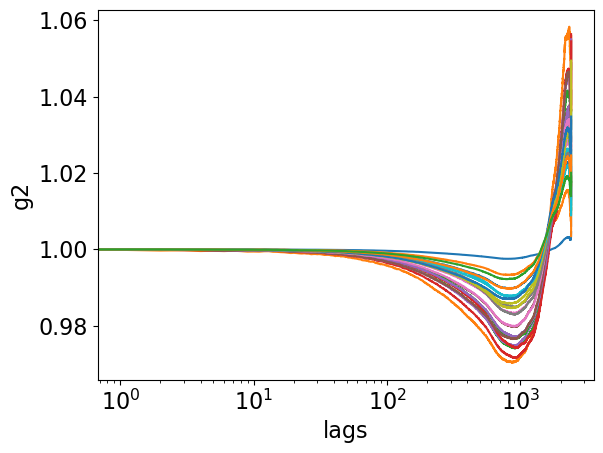

In [39]:
plt.figure()
plt.semilogx(tmp.T/tmp[:,0])
plt.xlabel('lags')
plt.ylabel('g2')
plt.show()

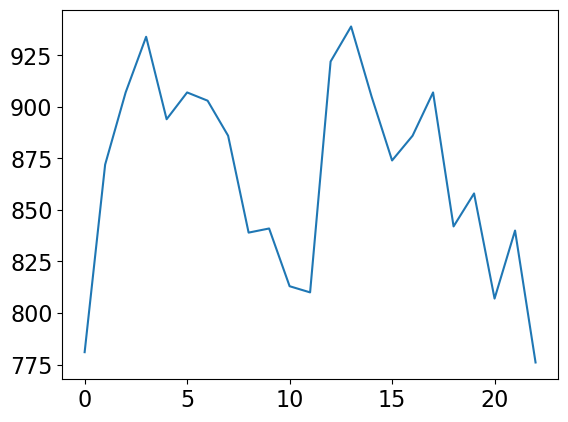

In [29]:
plt.plot([np.argmin(t) for t in tmp])

In [ ]:
from lmfit import Model, Parameter

def fit_func(t, A, tau, beta, c, **kwargs):
    return A * np.exp(-(t/tau)**beta) + c

results = []
for ul in np.unique(labels):
    mask = labels == ul
    g_ = g2_img[1:, mask].mean(axis=(-1))[:490]
    
    mod = Model(fit_func)
    params = mod.make_params(A=1, tau=100, beta=1, c=0.9)
    params['tau'].min = 1
    params['c'].min = 0.8
    params['A'].min = 0
    params['beta'].vary = True
    #params['beta'].max = 2
    params['beta'].min = 0
    out = mod.fit(g, t=np.arange(len(g_)), params=params)
    results.append(out)
    
    
    plt.figure()
    plt.plot(g_)
    plt.plot(out.best_fit)
    plt.show()